
## Import necessary libraries

In [1]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

C:\Users\luisl\AppData\Local\Temp\ipykernel_17848\269888456.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [4]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [5]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load and process input data

Check the texts which is filtered by keyword as well

In [6]:
import pickle
import os

# Rutas de los archivos
ruta_original = 'C:/Users/Luis/Desktop/personal/tfm_ia3_nodata/data/preprocessed/'
ruta_nueva = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/'
archivos = ['text_no_split.pickle', 'text_keyword.pickle']

# Intentar cargar los archivos
text_no_split = None
text_keyword = None

for archivo in archivos:
    try:
        # Intenta abrir el archivo en la ruta original
        with open(os.path.join(ruta_original, archivo), 'rb') as file:
            if archivo == 'text_no_split.pickle':
                text_no_split = pickle.load(file)
            elif archivo == 'text_keyword.pickle':
                text_keyword = pickle.load(file)
        print(f"Archivo {archivo} encontrado en la ruta original.")
    except FileNotFoundError:
        try:
            # Si no se encuentra en la ruta original, intenta en la nueva
            with open(os.path.join(ruta_nueva, archivo), 'rb') as file:
                if archivo == 'text_no_split.pickle':
                    text_no_split = pickle.load(file)
                elif archivo == 'text_keyword.pickle':
                    text_keyword = pickle.load(file)
            print(f"Archivo {archivo} encontrado en la nueva ruta.")
        except FileNotFoundError:
            print(f"Archivo {archivo} no encontrado en ninguna de las rutas.")

# Usar las variables text_no_split y text_keyword según sea necesario.


Archivo text_no_split.pickle encontrado en la nueva ruta.
Archivo text_keyword.pickle encontrado en la nueva ruta.


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


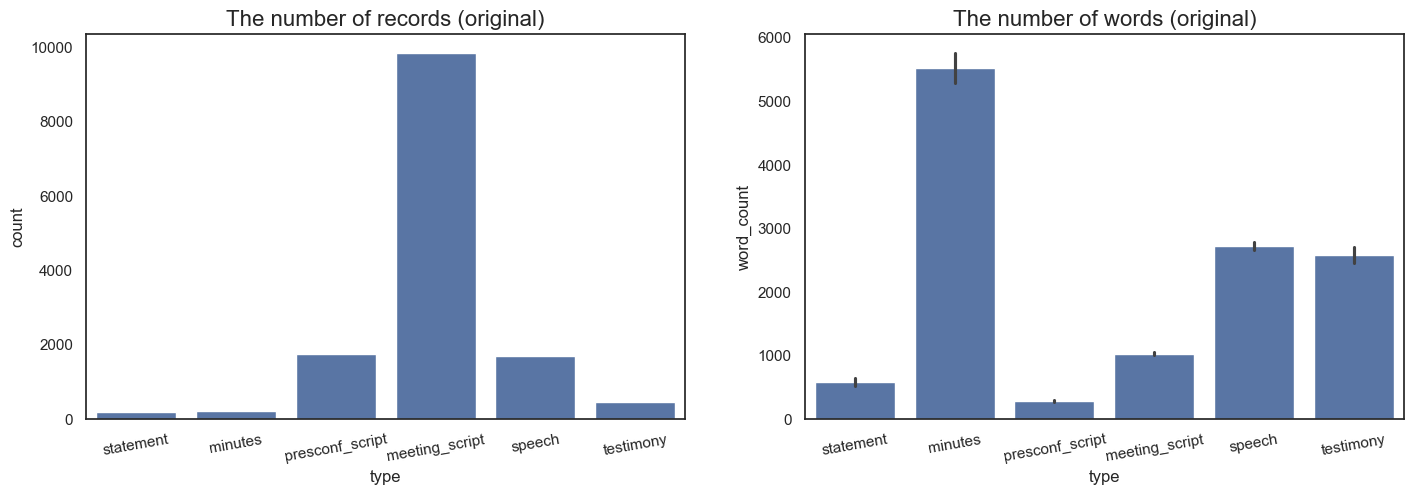

In [7]:
# Check the number of records per document type
def plot_num_rec_word(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)

# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,403,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,432,1,5.50,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,400,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


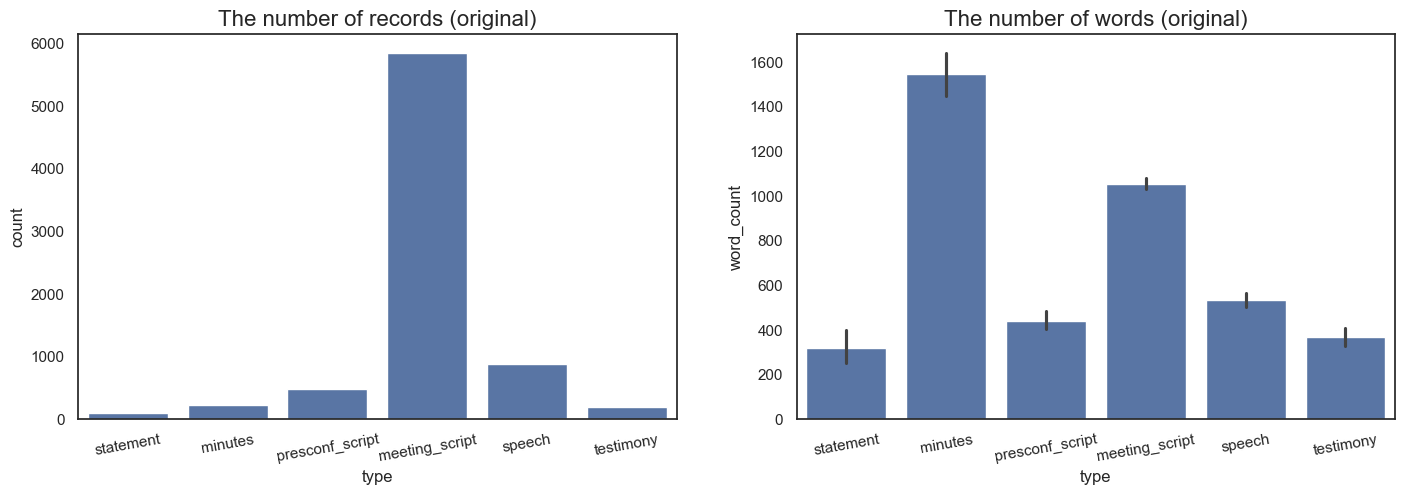

In [8]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [9]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe
Here, use all the texts but keywords filtere one would give better performance - to be checked.

(4339, 11)


  0%|          | 0/9852 [00:00<?, ?it/s]

(4597, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


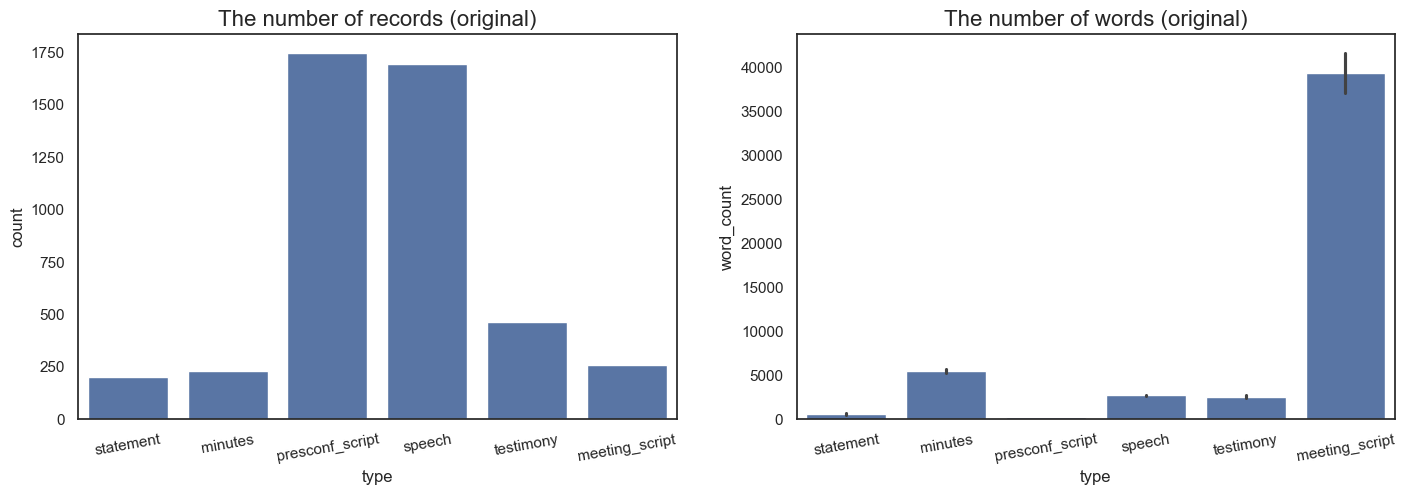

In [10]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row

    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

In [11]:
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [12]:
# Calcular el número total de filas en el DataFrame
num_total_filas = train_df.shape[0]

print("Número total de filas en el DataFrame:", num_total_filas)

Número total de filas en el DataFrame: 4597


In [13]:
# Supongamos que tienes un DataFrame llamado df y una variable específica llamada 'variable_especifica'
variable_especifica = 'next_decision'

# Contar el número de filas con valores NaN en la variable especificada
num_filas_nan = train_df[variable_especifica].isnull().sum()

print("Número de filas con NaN en la variable '{}': {}".format(variable_especifica, num_filas_nan))


Número de filas con NaN en la variable 'next_decision': 31


In [14]:
# Filtrar el DataFrame para seleccionar solo las filas con valores NaN en la variable especificada
filas_nan = train_df[train_df[variable_especifica].isnull()]

# Obtener los valores de la columna "date" correspondientes a las filas con valores NaN
fechas_nan = filas_nan['date']

print("Valores de 'date' correspondientes a filas con NaN en la variable '{}':".format(variable_especifica))
print(fechas_nan)

Valores de 'date' correspondientes a filas con NaN en la variable 'next_decision':
201    2023-12-13
2151   2023-12-13
2152   2023-12-13
2153   2023-12-13
2154   2023-12-13
2155   2023-12-13
2156   2023-12-13
2157   2023-12-13
2158   2023-12-13
2159   2023-12-13
2160   2023-12-13
2161   2023-12-13
2162   2023-12-13
2163   2023-12-13
2164   2023-12-13
2165   2023-12-13
2166   2023-12-13
2167   2023-12-13
2168   2023-12-13
2169   2023-12-13
2170   2023-12-13
2171   2023-12-13
2172   2023-12-13
2173   2023-12-13
2174   2023-12-13
2175   2023-12-13
2176   2023-12-13
2177   2023-12-13
2178   2023-12-13
2179   2023-12-13
2180   2023-12-13
Name: date, dtype: datetime64[ns]


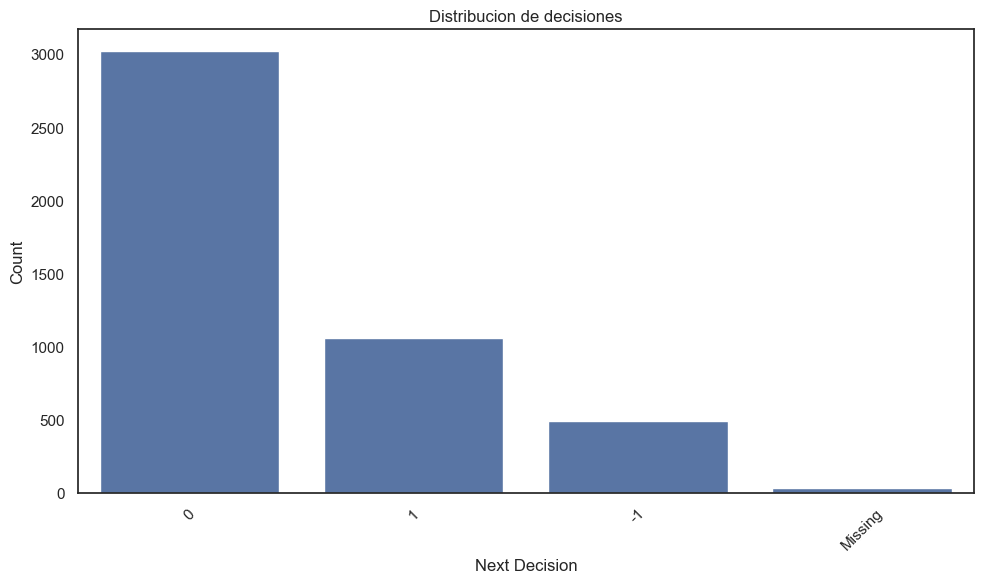

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
# Crear el gráfico de conteo
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='next_decision')

# Añadir etiquetas y título
plt.xlabel('Next Decision')
plt.ylabel('Count')
plt.title('Distribucion de decisiones')

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


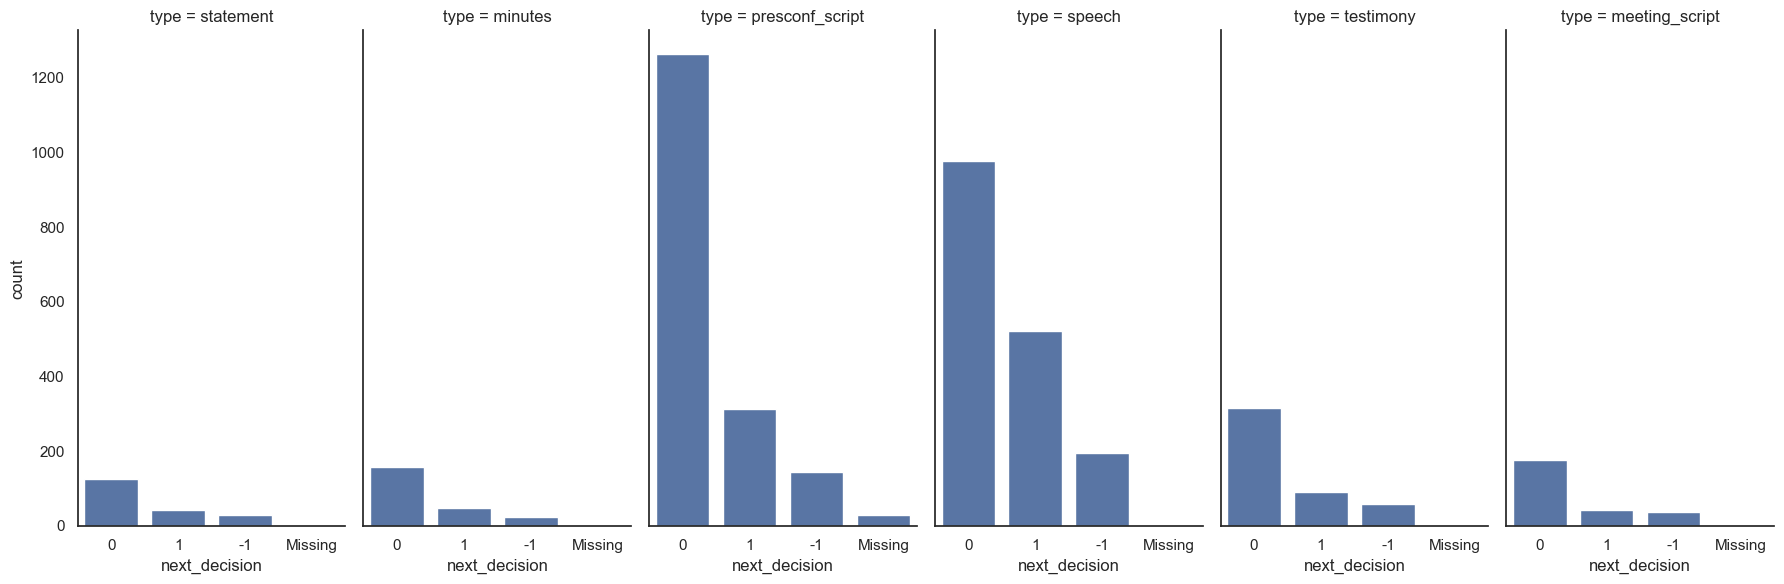

In [16]:
# Check balance of Rate Decision
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


C:\Users\luisl\AppData\Local\Temp\ipykernel_15376\4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
C:\Users\luisl\AppData\Local\Temp\ipykernel_15376\4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

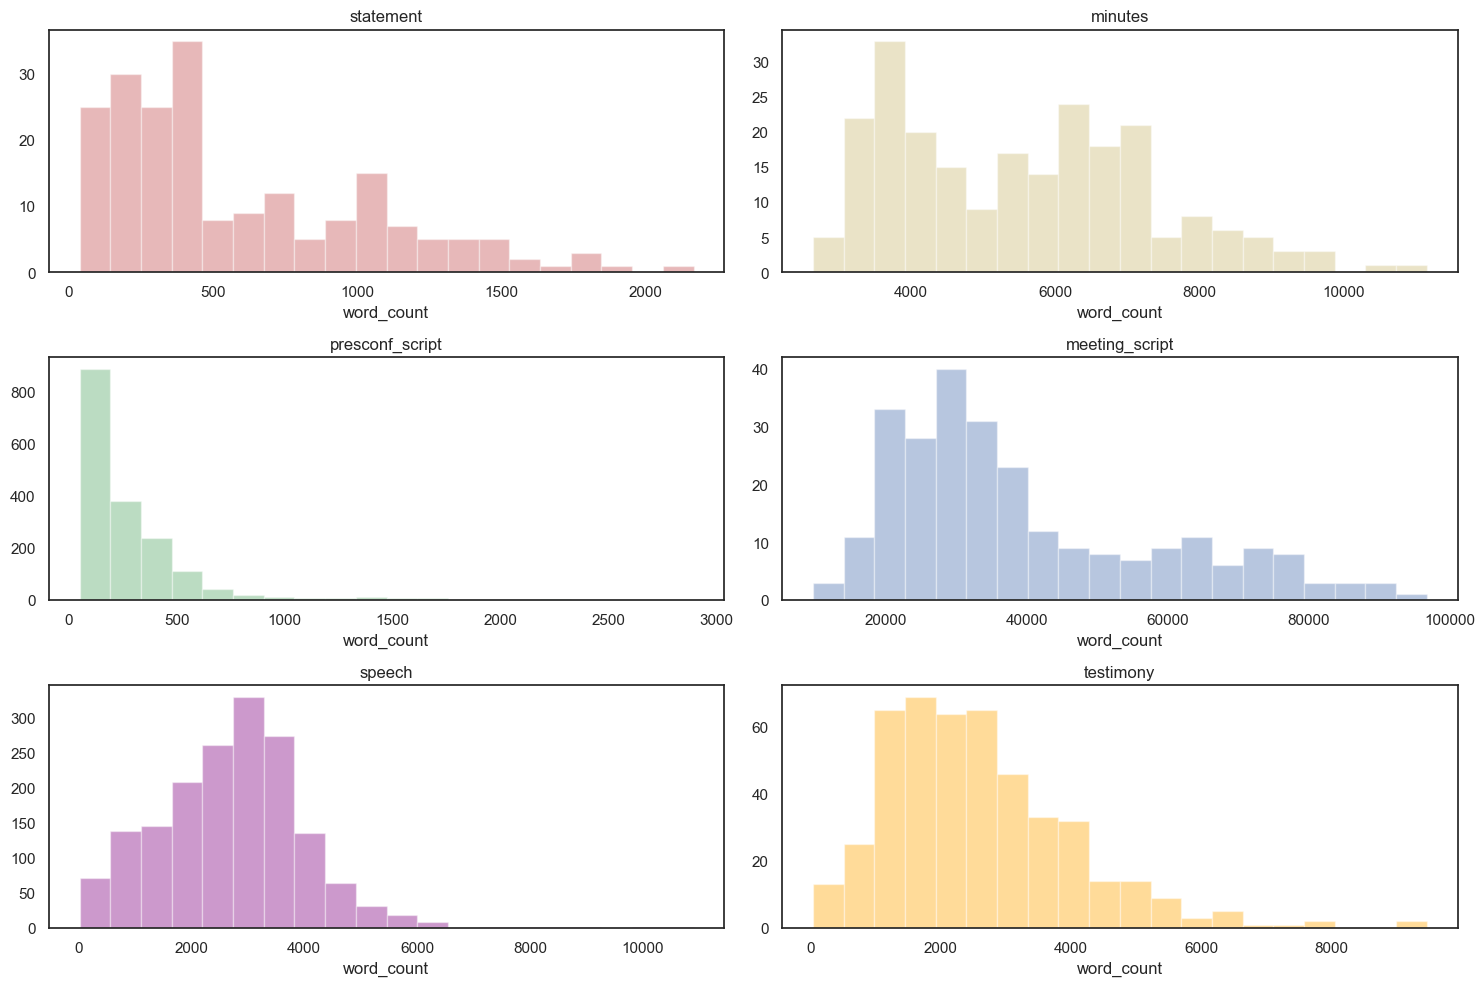

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
253,meeting_script,2014-04-30,FOMC Meeting Transcript,,78299,0,0.0,2014-06-18,0,0.0,"Good morning, everybody. Unfortunately, this i..."
254,meeting_script,2014-06-18,FOMC Meeting Transcript,,87191,0,0.0,2014-07-30,0,0.0,I'd like to begin by welcoming three people to...
255,meeting_script,2014-07-30,FOMC Meeting Transcript,,89115,0,0.0,2014-09-17,0,0.0,"Good morning, everybody. I would like to begin..."
256,meeting_script,2014-09-17,FOMC Meeting Transcript,,61267,0,0.0,2014-10-29,1,0.0,"Good morning, everybody.Our first two items th..."
257,meeting_script,2014-10-29,FOMC Meeting Transcript,,72330,1,0.0,2014-12-17,0,0.0,I'd like to call this meeting to order. Before...


In [17]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


## Load a trained model

In [18]:

train_sent_df = train_df[train_df['type'] != 'meeting_script']

In [19]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [20]:
train_sent_df.shape

(4339, 11)

In [21]:
# Supongamos que quieres contar los NaN en la columna 'next_decision' de train_sent_df
nans_count = train_sent_df['next_decision'].isna().sum()

print(f"Número de valores NaN en la columna 'next_decision': {nans_count}")


Número de valores NaN en la columna 'next_decision': 0


In [22]:
train_sent_df = train_sent_df.dropna(subset=['next_decision'])
train_sent_df.shape

(4339, 11)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

## Resumir los textos mediante modelado ##

In [24]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration

# Let's load the model and the tokenizer 
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Check GPU availability (assuming PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device) # If you want to use the Tensorflow model 



Using device: cuda


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [26]:
for idx, row in tqdm(train_sent_df.iterrows(), total=len(train_sent_df)):
  # Access text from dataframe
  text_to_summarize = row["text"]

  try:
    # Tokenize the text (without batching, truncation optional)
    input_ids = tokenizer(text_to_summarize, return_tensors="pt", truncation=True).input_ids.to(device)

    # Generate summary (assuming single output)
    output = model.generate(
        input_ids, 
        max_length=32, 
        num_beams=5, 
        early_stopping=True
    )

    # Decode the summary (handle potential multiple outputs)
    summary = tokenizer.decode(output[0], skip_special_tokens=True)  # Access first output

    # Update the dataframe with the summary
    train_sent_df.loc[idx, 'summary'] = summary

  except RuntimeError as e:
    print(f"Error during processing text '{text_to_summarize}': {e}")
    # Consider adding a placeholder for failed summaries (optional)
    # train_sent_df.loc[idx, 'summary'] = "Error: Summarization failed"

# Update progress bar after loop
tqdm.write("Summarization completed! Summaries added to 'summary' column.")

  0%|          | 0/4339 [00:00<?, ?it/s]

Summarization completed! Summaries added to 'summary' column.


guardar texto resumido como pickle

In [27]:
import pandas as pd
import pickle

# Assuming your DataFrame is loaded and assigned to a variable named 'df'

# Define the path and filename for the pickle file
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido.pkl'

# Open the file in binary write mode
with open(ruta_pickle, 'wb') as pickle_file:
  # Use pickle.dump to serialize the DataFrame and write it to the file
  pickle.dump(train_sent_df, pickle_file)

print("¡DataFrame guardado como archivo pickle exitosamente!")

¡DataFrame guardado como archivo pickle exitosamente!


cargar texto resumido 

In [3]:
import pickle

# Define the path to the pickle file (same as before)
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido.pkl'

# Open the file in binary read mode
with open(ruta_pickle, 'rb') as pickle_file:
  # Use pickle.load to deserialize the data and create a new DataFrame
  loaded_df = pickle.load(pickle_file)

print("¡DataFrame cargado del archivo pickle exitosamente!")

¡DataFrame cargado del archivo pickle exitosamente!


In [4]:
loaded_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,Decision to increase slightly the degree of pr...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,The committee decided to increase slightly the...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,The Federal Reserve will increase slightly the...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",The Board of Directors of the Federal Reserve ...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",The Board of Directors of the Federal Reserve ...


In [4]:
def equilibrar_columna_ignorando_missing(df, columna, valor_missing='Missing'):
    """
    Equilibra los valores en una columna específica de un DataFrame de pandas,
    ignorando los valores faltantes.
    
    Parámetros:
    - df: DataFrame de pandas.
    - columna: Nombre de la columna a equilibrar.
    - valor_missing: Valor que representa los datos faltantes en la columna.
    
    Retorna:
    - DataFrame equilibrado donde cada valor único en la columna especificada
      (excepto el valor_missing) tiene el mismo número de filas.
    """
    # Filtra los valores faltantes
    df_filtrado = df[df[columna] != valor_missing]
    
    # Calcula el número de filas para cada valor único en la columna filtrada
    counts = df_filtrado[columna].value_counts()
    
    # Encuentra el valor mínimo de filas entre los grupos
    min_count = counts.min()
    
    # Reduce cada grupo a este número mínimo de filas
    balanced_df = df_filtrado.groupby(columna).head(min_count).reset_index(drop=True)
    
    return balanced_df


In [5]:
# Uso de la función
# Suponiendo que train_sent_df es tu DataFrame, 'next_decision' es la columna a equilibrar,
# y 'Missing' representa los valores faltantes en esa columna
train_sent_df = equilibrar_columna_ignorando_missing(loaded_df, 'next_decision', 'Missing')

# Verificación del nuevo balance de clases (sin contar los missing)

In [6]:
print(train_sent_df['next_decision'].value_counts())

next_decision
0     453
1     453
-1    453
Name: count, dtype: int64


In [7]:
X = train_sent_df['summary'].to_list()


In [8]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,Decision to increase slightly the degree of pr...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,The committee decided to increase slightly the...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,The Federal Reserve will increase slightly the...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",The Board of Directors of the Federal Reserve ...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",The Board of Directors of the Federal Reserve ...


In [9]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['summary'].to_list()




In [10]:
nan_count = submuestra_df['next_decision'].isnull().sum()
nan_count

0

In [11]:
data = train_sent_df[['summary', 'next_decision']]
# Reemplazar los valores en la columna específica
data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})

C:\Users\luisl\AppData\Local\Temp\ipykernel_17848\1924414100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})
C:\Users\luisl\AppData\Local\Temp\ipykernel_17848\1924414100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})


In [12]:
data = data.rename(columns={'summary': 'text', 'next_decision': 'label'})

In [13]:
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en conjuntos de entrenamiento y prueba (80% train, 20% test)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Mostrar los tamaños de los conjuntos de train y test
print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de prueba:", len(test_df))

Tamaño del conjunto de entrenamiento: 1087
Tamaño del conjunto de prueba: 272


In [14]:
train_data = train_df.to_dict(orient='records')
val_data = test_df.to_dict(orient='records')
data = data.to_dict(orient='records')



In [15]:
train_data

[{'text': 'Chairman Powell answers questions from reporters.', 'label': 2},
 {'text': 'Here is the full text of the remarks by Boston Fed chair Evans:',
  'label': 0},
 {'text': 'Staff presented two illustrative scenarios for long-run target portfolio composition.',
  'label': 1},
 {'text': 'Chair Powell: Trade policy uncertainty is one of them.',
  'label': 0},
 {'text': 'The Federal Open Market Committee decided to keep its target for the federal funds rate at 1 percent.',
  'label': 1},
 {'text': "Powell: China reopening is a risky situation, but it doesn't seem likely to have material effect",
  'label': 2},
 {'text': 'T-bill purchases and repo operations have been described as liquidity.',
  'label': 0},
 {'text': 'Information received since the Federal Open Market Committee met in January suggests that economic activity has continued to strengthen.',
  'label': 1},
 {'text': "Chairman: I don't accept premise that Fed has been passive.",
  'label': 1},
 {'text': 'I am pleased to b

fine tuning del primer modelo

In [25]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
import os

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_{lr}_{batch_size}.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/68 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\luisl\AppData\Local\Temp\ipykernel_10744\738944181.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 1.1799, Train Accuracy: 0.3864
Validation Loss: 1.0410, Validation Accuracy: 0.4816
Saving best model with validation accuracy: 0.4816


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.9852, Train Accuracy: 0.5398
Validation Loss: 0.9926, Validation Accuracy: 0.4816


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.8457, Train Accuracy: 0.6173
Validation Loss: 0.8993, Validation Accuracy: 0.5772
Saving best model with validation accuracy: 0.5772


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.6981, Train Accuracy: 0.7203
Validation Loss: 0.9313, Validation Accuracy: 0.6181
Saving best model with validation accuracy: 0.6181


  0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 

carga del primer modelo reentrenado

In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/con_resumen/best_model_1e-05_32.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is booming!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is booming!': positive


twitter-roberta-base-sentiment Model¶


In [23]:
import torch
import numpy as np
import scipy.special
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_roberta.load_state_dict(torch.load(model_path))
model_roberta.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Asumiendo que X_submuestra es tu lista de textos a analizar
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Procesando predicciones"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        # Obtener las logits del modelo
        logits = model_roberta(**input_sequence).logits
        # Aplicar softmax en la GPU
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    
    sentimiento_general = labels[np.argmax(scores)]
    probabilidad_general = np.max(scores)
    
    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


Procesando predicciones: 100%|██████████| 1359/1359 [01:01<00:00, 22.25it/s]


In [24]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
673,presconf_script,2014-12-17,FOMC Press Conference Transcript,STEVE BECKNER,106,0,0.00,2017-06-14,1,NaN,"Good afternoon, Chair Yellen. Steve Beckner of...",MNI's Beckner asks Yellen about balance sheet ...,positive
552,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,256,0,0.00,2012-06-20,-1,0.00,"Well, I'm very comfortable with the consensus ...",Here is the full text of Ben Bernanke's press ...,neutral
1272,speech,2019-07-01,The Federal Reserve's Review of Its Monetary P...,Vice Chair Richard H. Clarida,2753,<NA>,NaN,2019-07-31,-1,2.00,I am delighted to be in Helsinki at this impor...,Below is the text of Fed chair Janet Yellen's ...,negative
389,minutes,2018-09-26,FOMC Meeting Minutes,Jerome Powell,6133,1,2.00,2018-11-08,0,2.00,Developments in Financial Markets and Open Mar...,Manager noted that U.S. equity markets had pos...,neutral
281,minutes,2002-05-07,FOMC Meeting Minutes,Alan Greenspan,3314,0,1.75,2002-06-26,0,1.75,"By unanimous vote, the Committee approved the ...",The Committee decided to extend for one year t...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,presconf_script,2022-05-04,FOMC Press Conference Transcript,MICHELLE SMITH,413,1,0.75,2022-06-15,1,1.50,Thanks. We'll go to Nancy for the last questio...,Black unemployment rate is roughly double the ...,positive
358,minutes,2011-11-02,FOMC Meeting Minutes,Ben Bernanke,6664,0,0.00,2011-11-28,0,0.00,Developments in Financial Markets and the Fede...,Committee took no action at meeting on Septemb...,neutral
530,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,377,0,0.00,2012-03-13,0,0.00,"Well, the Federal Reserve obviously has a very...",Chairman: There is no official position on pri...,neutral
261,minutes,2000-06-28,FOMC Meeting Minutes,Alan Greenspan,3679,0,6.50,2000-08-22,0,6.50,"By unanimous vote, David J. Stockton was elect...",The Federal Reserve releases the minutes of th...,neutral


yiyanghkust/finbert-tone Model

In [17]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_roberta = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_2_{lr}_{batch_size}.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/68 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\luisl\AppData\Local\Temp\ipykernel_14560\975409393.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 1.9009, Train Accuracy: 0.4186
Validation Loss: 1.0172, Validation Accuracy: 0.4779
Saving best model with validation accuracy: 0.4779


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.9468, Train Accuracy: 0.5539
Validation Loss: 0.9266, Validation Accuracy: 0.5993
Saving best model with validation accuracy: 0.5993


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.8232, Train Accuracy: 0.6395
Validation Loss: 0.9431, Validation Accuracy: 0.6066
Saving best model with validation accuracy: 0.6066


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.7489, Train Accuracy: 0.6843
Validation Loss: 0.9183, Validation Accuracy: 0.6250
Saving best model with validation accuracy: 0.6250


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.5549, Train Accuracy: 0.7654
Validation Loss: 0.9697, Validation Accuracy: 0.6042


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.4673, Train Accuracy: 0.8233
Validation Loss: 0.9608, Validation Accuracy: 0.6354
Saving best model with validation accuracy: 0.6354


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3964, Train Accuracy: 0.8573
Validation Loss: 1.0096, Validation Accuracy: 0.6687
Saving best model with validation accuracy: 0.6687


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.3253, Train Accuracy: 0.8841
Validation Loss: 1.0337, Validation Accuracy: 0.6656


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.2940, Train Accuracy: 0.8952
Validation Loss: 1.1357, Validation Accuracy: 0.6438
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.4163, Train Accuracy: 0.8435
Validation Loss: 1.3861, Validation Accuracy: 0.5956


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2831, Train Accuracy: 0.9025
Validation Loss: 1.4531, Validation Accuracy: 0.6103
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.2421, Train Accuracy: 0.9172
Validation Loss: 1.4188, Validation Accuracy: 0.6424


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1792, Train Accuracy: 0.9475
Validation Loss: 1.4523, Validation Accuracy: 0.6076
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1808, Train Accuracy: 0.9328
Validation Loss: 1.4654, Validation Accuracy: 0.6719
Saving best model with validation accuracy: 0.6719


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1266, Train Accuracy: 0.9512
Validation Loss: 1.5308, Validation Accuracy: 0.6656


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.1216, Train Accuracy: 0.9595
Validation Loss: 1.5721, Validation Accuracy: 0.6656
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3770, Train Accuracy: 0.8804
Validation Loss: 2.0530, Validation Accuracy: 0.5735


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.3115, Train Accuracy: 0.8952
Validation Loss: 1.5404, Validation Accuracy: 0.6103
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3098, Train Accuracy: 0.8998
Validation Loss: 1.9115, Validation Accuracy: 0.6528


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2126, Train Accuracy: 0.9291
Validation Loss: 1.8048, Validation Accuracy: 0.6528
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1721, Train Accuracy: 0.9430
Validation Loss: 1.8680, Validation Accuracy: 0.6438


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1470, Train Accuracy: 0.9485
Validation Loss: 1.6203, Validation Accuracy: 0.6687
Early stopping triggered after 2 epochs without improvement


carga de segundo modelo reentrenado

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/con_resumen/best_model_2_2e-05_64.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is doing great!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is doing great!': positive


In [26]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd
from tqdm.auto import tqdm

# Inicialización del modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert.load_state_dict(torch.load(model_path))
finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert.to(device)

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Asumiendo que submuestra_df es tu DataFrame y tiene una columna 'text'
predicted_finbert_tone = []

for text in tqdm(submuestra_df['summary'], desc="Analizando sentimientos"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        result = nlp(text)[0]
    
    sentimiento_final = result['label'].lower()
    predicted_finbert_tone.append(sentimiento_final)

# Añadir los resultados al DataFrame
submuestra_df['predicted_finbertTone'] = predicted_finbert_tone


Analizando sentimientos:   0%|          | 0/1359 [00:00<?, ?it/s]

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


ProsusAI/finbert Model


In [18]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_roberta = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_3_{lr}_{batch_size}.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/68 [00:00<?, ?it/s]

C:\Users\luisl\AppData\Local\Temp\ipykernel_14560\2617414119.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 1.2285, Train Accuracy: 0.4148
Validation Loss: 1.0423, Validation Accuracy: 0.4890
Saving best model with validation accuracy: 0.4890


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.9437, Train Accuracy: 0.5521
Validation Loss: 0.9941, Validation Accuracy: 0.5515
Saving best model with validation accuracy: 0.5515


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.7756, Train Accuracy: 0.6534
Validation Loss: 0.9230, Validation Accuracy: 0.6287
Saving best model with validation accuracy: 0.6287


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.6019, Train Accuracy: 0.7599
Validation Loss: 0.9453, Validation Accuracy: 0.6424
Saving best model with validation accuracy: 0.6424


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.4889, Train Accuracy: 0.8132
Validation Loss: 1.0257, Validation Accuracy: 0.6389


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.4111, Train Accuracy: 0.8519
Validation Loss: 1.0511, Validation Accuracy: 0.6076
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3378, Train Accuracy: 0.8914
Validation Loss: 1.0954, Validation Accuracy: 0.6000


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2955, Train Accuracy: 0.9024
Validation Loss: 1.1322, Validation Accuracy: 0.6125
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3598, Train Accuracy: 0.8721
Validation Loss: 1.3259, Validation Accuracy: 0.5735


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2909, Train Accuracy: 0.8988
Validation Loss: 1.2885, Validation Accuracy: 0.6066
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.2669, Train Accuracy: 0.8988
Validation Loss: 1.2181, Validation Accuracy: 0.6111


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1885, Train Accuracy: 0.9292
Validation Loss: 1.3149, Validation Accuracy: 0.6250
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1644, Train Accuracy: 0.9402
Validation Loss: 1.3017, Validation Accuracy: 0.6594
Saving best model with validation accuracy: 0.6594


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1414, Train Accuracy: 0.9458
Validation Loss: 1.3861, Validation Accuracy: 0.6125


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.1190, Train Accuracy: 0.9521
Validation Loss: 1.4893, Validation Accuracy: 0.6344
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3057, Train Accuracy: 0.8860
Validation Loss: 1.4529, Validation Accuracy: 0.6029


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2555, Train Accuracy: 0.9099
Validation Loss: 1.5857, Validation Accuracy: 0.6103
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.2223, Train Accuracy: 0.9099
Validation Loss: 1.6202, Validation Accuracy: 0.6007


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1723, Train Accuracy: 0.9355
Validation Loss: 1.6212, Validation Accuracy: 0.6042
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1557, Train Accuracy: 0.9384
Validation Loss: 1.6767, Validation Accuracy: 0.6031


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1175, Train Accuracy: 0.9549
Validation Loss: 1.7897, Validation Accuracy: 0.5875
Early stopping triggered after 2 epochs without improvement


cargar tercer modelo reentrenado

In [27]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/con_resumen/best_model_3_2e-05_64.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is doing great!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")


Predicted sentiment for 'The stock market is doing great!': negative


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as np

# Inicialización del tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finbert.to(device)

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in tqdm(X_submuestra, desc="Procesando predicciones FinBERT"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        logits = model_finbert(**input_sequence).logits
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        scores_dict = {
            label: score
            for label, score in zip(model_finbert.config.id2label.values(), scores)
        }
        sentimiento = max(scores_dict, key=scores_dict.get)
        probabilidad = max(scores_dict.values())
    
    preds.append(sentimiento)
    preds_proba.append(probabilidad)



Procesando predicciones FinBERT:   0%|          | 0/1359 [00:00<?, ?it/s]

In [29]:
submuestra_df['predicted_finbert'] =preds

hacer la columna sentiment en el dataset de entrenamiento teniendo en cuenta las agregaciones de key y cambiar de 1 a positive etc

In [30]:

y = submuestra_df['next_decision'].to_list()
y = [ 'neutral' if value == 0 else 'positive' if value == 1 else 'negative' for value in y ]


In [31]:
submuestra_df.tail()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta,predicted_finbertTone,predicted_finbert
835,presconf_script,2022-05-04,FOMC Press Conference Transcript,MICHELLE SMITH,413,1,0.75,2022-06-15,1,1.5,Thanks. We'll go to Nancy for the last questio...,Black unemployment rate is roughly double the ...,positive,negative,neutral
358,minutes,2011-11-02,FOMC Meeting Minutes,Ben Bernanke,6664,0,0.00,2011-11-28,0,0.0,Developments in Financial Markets and the Fede...,Committee took no action at meeting on Septemb...,neutral,positive,neutral
530,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,377,0,0.00,2012-03-13,0,0.0,"Well, the Federal Reserve obviously has a very...",Chairman: There is no official position on pri...,neutral,positive,negative
261,minutes,2000-06-28,FOMC Meeting Minutes,Alan Greenspan,3679,0,6.50,2000-08-22,0,6.5,"By unanimous vote, David J. Stockton was elect...",The Federal Reserve releases the minutes of th...,neutral,negative,neutral
1188,speech,2003-06-16,Managing business risks,Governor Susan Schmidt Bies,2644,<NA>,NaN,2003-06-25,-1,1.0,Thank you for inviting me to participate in th...,Here is the text of Fed governor's speech at t...,negative,neutral,positive


In [32]:
submuestra_df['text'][0]

"Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates. The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion. Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989."

## Model evaluation

In [37]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [38]:
evaluate_model_accuracy('ProsusAI/finbert', preds)
evaluate_model_accuracy('cardiffnlp/twitter-roberta-base-sentiment', preds_roberta)
evaluate_model_accuracy('yiyanghkust/finbert-tone', submuestra_df.predicted_finbertTone)

Model: ProsusAI/finbert - Accuracy-Score: 0.0522
Model: cardiffnlp/twitter-roberta-base-sentiment - Accuracy-Score: 0.8447
Model: yiyanghkust/finbert-tone - Accuracy-Score: 0.0456


In [40]:
print(classification_report(y,preds))
print(classification_report(y,preds_roberta))
print(classification_report(y,submuestra_df.predicted_finbertTone))

              precision    recall  f1-score   support

    negative       0.06      0.06      0.06       453
     neutral       0.03      0.03      0.03       453
    positive       0.06      0.06      0.06       453

    accuracy                           0.05      1359
   macro avg       0.05      0.05      0.05      1359
weighted avg       0.05      0.05      0.05      1359

              precision    recall  f1-score   support

    negative       0.83      0.86      0.84       453
     neutral       0.84      0.88      0.86       453
    positive       0.87      0.80      0.83       453

    accuracy                           0.84      1359
   macro avg       0.85      0.84      0.84      1359
weighted avg       0.85      0.84      0.84      1359

              precision    recall  f1-score   support

    negative       0.06      0.06      0.06       453
     neutral       0.04      0.04      0.04       453
    positive       0.04      0.04      0.04       453

    accuracy        

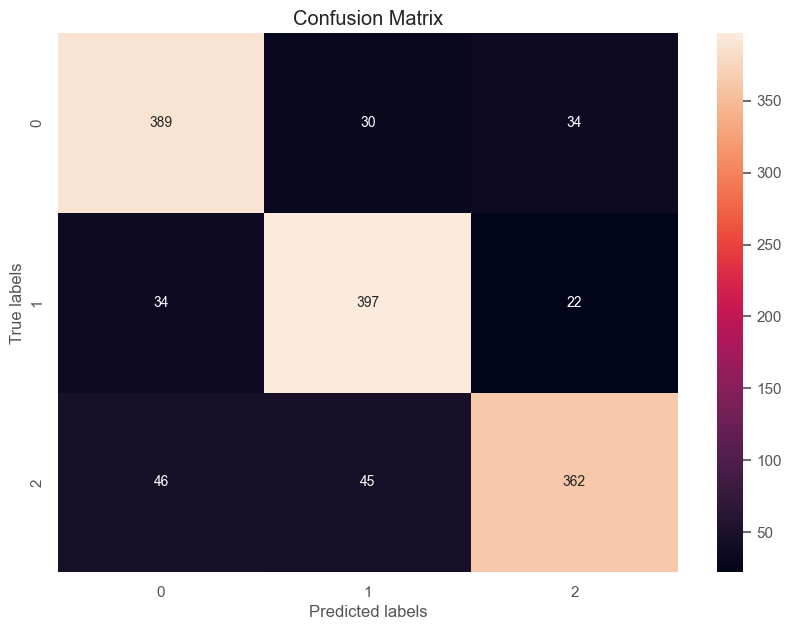

In [41]:
cm = confusion_matrix(y, preds_roberta)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

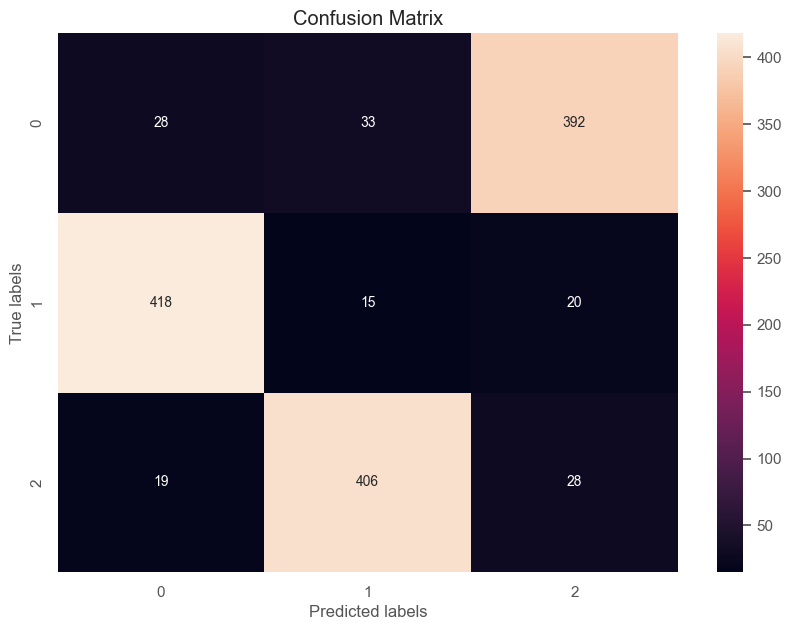

In [42]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

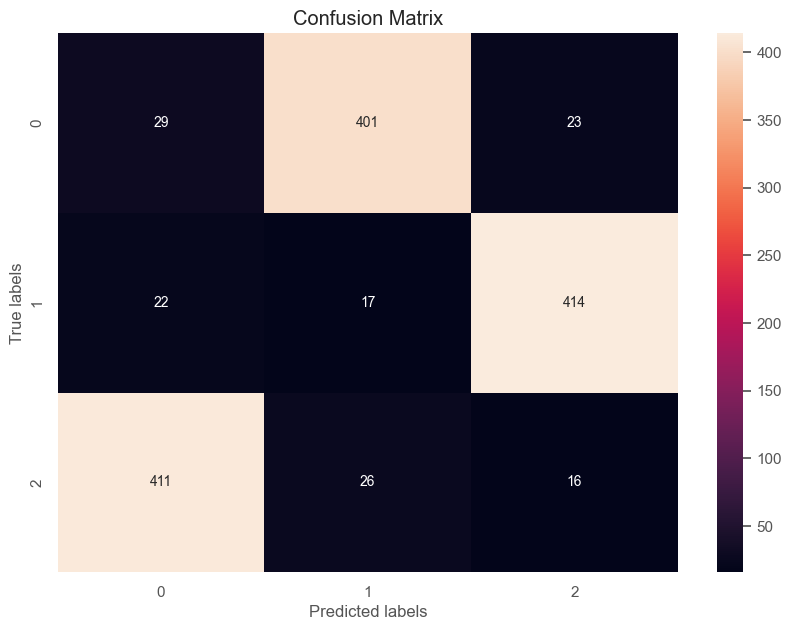

In [43]:
cm = confusion_matrix(y, submuestra_df.predicted_finbertTone)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()